In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda


In [3]:
#Transforms

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    "train" : transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((270,90)),
        transforms.Normalize(mean, std)
    ]),
    
    "test" : transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((270,90)),
        transforms.Normalize(mean, std),
    ]),
}

In [4]:
#data
from torch.utils.data import Dataset, DataLoader
import os
import cv2

path_folder = "D:/Pytorch/data/combine_cls"

class DataPepsi(Dataset):
    
    def __init__(self, path_folder, status , transforms = None):
        
        self.transforms = transforms
        
        if status == "train":
            
            path_good = path_folder + "/" + status + "/" + "good"
            folder_good = os.listdir(path_good)
            label_good = [0 for i in range(len(folder_good))]
            image_good = []
            for i in folder_good:
                img = cv2.imread(path_good + "/" + i)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                image_good.append(img)
            
            path_error = path_folder + "/" + status + "/" + "error"
            folder_error = os.listdir(path_error)
            label_error = [1 for i in range(len(folder_error))]
            image_error = []
            for i in folder_error:
                img = cv2.imread(path_error + "/" + i)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                image_error.append(img)
            
            
            self.image = image_good + image_error
            self.label = label_good + label_error
            
        else:
            path = path_folder + "/" + status
            folder = os.listdir(path)
            image_list = []
            label_list = []
            for i in folder:
                img = cv2.imread(path + "/" + i)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                image_list.append(img)
                if i[0] == 'g':
                    label_list.append(0)
                else:
                    label_list.append(1)
            
            self.image = image_list
            self.label = label_list 
                
            
    def __getitem__(self, index):
        image = self.image[index]
        label = self.label[index]
        
        if self.transforms:
            image = self.transforms(image)
        label = torch.tensor(label, dtype=int)
        return image, label
    
    def __len__(self):
        return len(self.image)
            
            
train_set = DataPepsi(path_folder, "train", transforms=data_transforms["train"])
test_set = DataPepsi(path_folder, "test", transforms=data_transforms["test"])


In [5]:
print(f"Total train data: {len(train_set)}")
print(f"Total test data: {len(test_set)}")

Total train data: 1942
Total test data: 227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


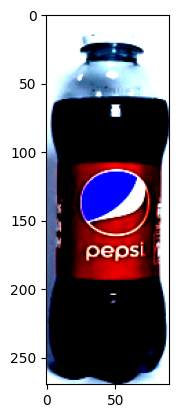

In [6]:
#test
import matplotlib.pyplot as plt
img_test, label_test = train_set[0]

img_np = img_test.numpy()
img_np = np.transpose(img_np, (1,2,0))

plt.imshow(img_np)
plt.show()

In [7]:
# data loader
train_loader = DataLoader(dataset= train_set,
                          batch_size= 32,
                          shuffle=True,)

test_loader = DataLoader(dataset=test_set,
                         batch_size=32,
                         shuffle=False)

In [8]:
#test dataloader
sample = iter(train_loader)
one = next(sample)
print(len(one[0]))
print(one[1])

32
tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1])


In [9]:
#model 
class ModelCNN(nn.Module):
    def __init__(self, classes):
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.maxpool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.maxpool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(128)

        self.avgpool = nn.AdaptiveMaxPool2d((16,16))
        
        self.fc1 = nn.Linear(16*16*128, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dr = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool1(out)
        out = self.bn1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool2(out)
        out = self.bn2(out)
        
        out = self.avgpool(out)
        
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.bn3(out)
        out = self.dr(out)
        out = self.fc2(out)
        
        out = torch.softmax(out, dim = 1)
        
        return out
        

In [10]:
# test model
model = ModelCNN(2)
sample = torch.rand([32, 3, 270, 90])
output = model(sample)
print(output.shape)

torch.Size([32, 2])


In [42]:
lr = 0.001

# hyperparameter | set up loss, optimizer 

num_epochs = 20

# loss
criterion = nn.CrossEntropyLoss()

# optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

#total_step
total_step = len(train_loader)

In [43]:
model = model.to(device)

In [44]:
#training 

loss_info = []
ACC = []

model.train()

for epoch in range(num_epochs):
    
    acc_info = 0
    
    for i, (image, label) in  enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        
        output = model(image)
        
        _, label_pre = torch.max(output, 1)
        
        acc_info += torch.sum(label == label_pre).item()
        
        loss = criterion(output, label)
        loss.backward()
        
        optimizer.step()
        
        
        if (i + 1) % 15 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}] | Step [{i + 1}/{total_step}]: Loss: {loss.item():.4f}')
            
    ACC.append(acc_info/len(train_set))
    loss_info.append(loss.item())
    
    print(f"Acc: {acc_info/len(train_set)}")
    print("-"*50)
        
            
print("Finished training")
        

Epoch [1/20] | Step [15/61]: Loss: 0.4090
Epoch [1/20] | Step [30/61]: Loss: 0.3853
Epoch [1/20] | Step [45/61]: Loss: 0.4122
Epoch [1/20] | Step [60/61]: Loss: 0.4656
Acc: 0.8717816683831102
--------------------------------------------------
Epoch [2/20] | Step [15/61]: Loss: 0.3911
Epoch [2/20] | Step [30/61]: Loss: 0.3256
Epoch [2/20] | Step [45/61]: Loss: 0.3760
Epoch [2/20] | Step [60/61]: Loss: 0.3212
Acc: 0.9433573635427395
--------------------------------------------------
Epoch [3/20] | Step [15/61]: Loss: 0.3852
Epoch [3/20] | Step [30/61]: Loss: 0.4348
Epoch [3/20] | Step [45/61]: Loss: 0.3509
Epoch [3/20] | Step [60/61]: Loss: 0.3329
Acc: 0.9577754891864058
--------------------------------------------------
Epoch [4/20] | Step [15/61]: Loss: 0.3151
Epoch [4/20] | Step [30/61]: Loss: 0.3475
Epoch [4/20] | Step [45/61]: Loss: 0.3162
Epoch [4/20] | Step [60/61]: Loss: 0.3533
Acc: 0.9654994850669413
--------------------------------------------------
Epoch [5/20] | Step [15/61]:

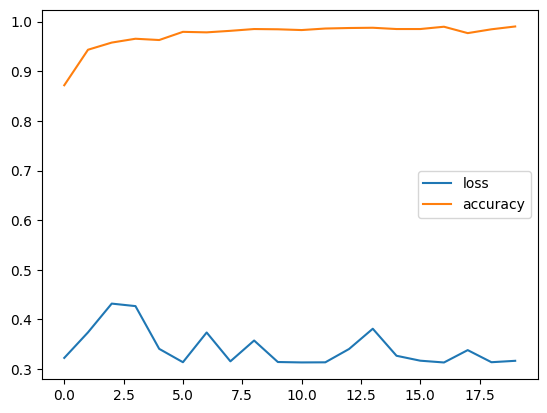

In [45]:
import matplotlib.pyplot as plt

len_loss = len(loss_info)
x = [i for i in range(len_loss)]

len_acc = len(ACC)
x_ = [i for i in range(len_acc)]

plt.plot(x,loss_info, label = "loss")
plt.plot(x_,ACC, label = "accuracy")
plt.legend()
plt.show()

In [22]:
# PATH = "model_FP32.pth"
# torch.save(model, PATH)

In [49]:
model = torch.load("model_FP32.pth")

In [57]:
#Test
import time
model.eval()

with torch.no_grad():
    acc_test = 0
    start = time.time()
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)
        label = label.to(device)

        output = model(image)
        
        _, label_pre = torch.max(output, 1)
        
        acc_test += torch.sum(label_pre == label).item()
    print(f"Time: {round(time.time() - start, 5)} s") 
        
print(f"Accuracy = {100*(acc_test/len(test_set))}")

Time: 0.51712 s
Accuracy = 99.55947136563876


## Optimize (Mixed Precision Training)

`Ưu điểm`:

+ Giảm dung lượng GPU yêu cầu cho các phép tính: Do các phép tính diễn ra trên fp16 nên dung lượng tính toán giảm nhiều.
+ Hiệu quả trên một số phần cứng hiện đại : Một số phần cứng GPU Nvidia, được tối ưu hóa cho các phép tính FP16, cho kết quả infer nhanh hơn.
+ Tăng tốc độ huấn luyện: Do phần forward tính toán trên FP16 nên việc tính toán nhanh.

`Nhược điểm`:
+ Không phải GPU Nvidia nào hỗ trợ tốt FP16: một số phần cứng chạy trên FP32 nhanh hơn FP16.

In [25]:
model.float()
model.half()
torch.save(model,"model_FP16.pth")

In [58]:
model = torch.load("model_FP16.pth")

In [66]:
import time
model.eval()

with torch.no_grad():
    acc_test = 0
    start = time.time()
    for i, (image, label) in enumerate(test_loader):
        image = image.half().to(device)  # Convert image to half precision and move to device
        label = label.to(device)

        output = model(image)

        _, label_pre = torch.max(output, 1)

        acc_test += torch.sum(label_pre == label).item()
    print(f"Time: {round(time.time() - start, 5)} s")

print(f"Accuracy = {100 * (acc_test / len(test_set))}%")


Time: 0.25611 s
Accuracy = 99.55947136563876%
